# Boosting - Diabetes Dataset

# Importamos las librerias a utilizar

In [1]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *
from imblearn.metrics import specificity_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# 1.1 Importamos el dataframe limpio

In [2]:
df = pd.read_pickle('/workspaces/carlos060495-intro-ml/data/processed/diabetes_clean.pkl')

print("✅ Dataframe cargado exitosamente")
print(f"📊 Forma del dataframe: {df.shape}")
df.head()

✅ Dataframe cargado exitosamente
📊 Forma del dataframe: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# 2.1 Train Test Split

In [3]:
# Separar características y variable objetivo
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamos el modelo de Boosting con hiperparámetros mejorados
model = GradientBoostingClassifier(
    n_estimators=100,        # Más árboles para mejor aprendizaje
    learning_rate=0.1,       # Tasa de aprendizaje más razonable
    max_depth=3,             # Profundidad típica en boosting
    min_samples_leaf=5,      # Menos restrictivo
    random_state=42          # Para reproducibilidad
)
model.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [4]:
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

In [5]:
# Realizamos predicciones en el conjunto de entrenamiento y prueba
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

# Evaluamos el rendimiento del modelo
get_metrics(y_train, y_test, train_pred, test_pred)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.941368,0.910891,0.923197,0.963351,0.863850,0.982544
Test,0.753247,0.666667,0.739394,0.644068,0.690909,0.787879
Diferencia,0.188121,0.244224,0.183803,0.319283,0.172941,0.194665


# 3.1 Hiperparametros

In [6]:
# Espacio de búsqueda para GradientBoostingClassifier
param_grid = {
    'n_estimators': [100, 200],           
    'learning_rate': [0.05, 0.1],         
    'max_depth': [3, 4],                  
    'min_samples_split': [2, 5],          
    'min_samples_leaf': [1, 2],           
    'subsample': [0.8, 1.0]               
}


# GridSearchCV
grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1',  # Métrica apropiada para clasificación
    cv=5,
    verbose=2,
    n_jobs=-1
)

print("🔍 Buscando los mejores hiperparámetros para Gradient Boosting...")

# Ajuste
grid_search.fit(X_train, y_train)

print("\n✅ Búsqueda completada!")
print("=" * 50)
print("🏆 MEJORES HIPERPARÁMETROS:")
print("=" * 50)
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")
print("=" * 50)
print(f"Mejor F1-Score (CV): {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

🔍 Buscando los mejores hiperparámetros para Gradient Boosting...
Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, m

# 3.2 Evaluación del Modelo Optimizado

In [7]:
# Realizamos predicciones con el modelo optimizado
best_test_pred = best_model.predict(X_test)
best_train_pred = best_model.predict(X_train)

# Evaluamos el rendimiento del modelo optimizado
best_metrics = get_metrics(y_train, y_test, best_train_pred, best_test_pred)
print("📊 Métricas del Modelo Optimizado (GridSearchCV):")
print("=" * 60)
best_metrics

📊 Métricas del Modelo Optimizado (GridSearchCV):


,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.983713,0.976077,0.977626,0.995122,0.957746,0.997506
Test,0.714286,0.627119,0.705051,0.587302,0.672727,0.737374
Diferencia,0.269428,0.348958,0.272576,0.407820,0.285019,0.260132


# 3.3 Comparación: Modelo Base vs Modelo Optimizado

In [8]:
# Obtener métricas del modelo base
base_metrics = get_metrics(y_train, y_test, train_pred, test_pred)

# Crear comparación
print("📊 COMPARACIÓN DE MODELOS GRADIENT BOOSTING")
print("=" * 70)
print("\n🔹 Modelo Base:")
print(base_metrics[['Accuracy', 'F1', 'Recall', 'Precision']].loc['Test'])
print("\n🔹 Modelo Optimizado (GridSearchCV):")
print(best_metrics[['Accuracy', 'F1', 'Recall', 'Precision']].loc['Test'])

# Calcular mejora porcentual
mejora = ((best_metrics.loc['Test'] - base_metrics.loc['Test']) / base_metrics.loc['Test'] * 100)
print("\n📈 Mejora Porcentual:")
print("=" * 70)
for metric in ['Accuracy', 'F1', 'Recall', 'Precision']:
    print(f"{metric}: {mejora[metric]:+.2f}%")
print("=" * 70)

📊 COMPARACIÓN DE MODELOS GRADIENT BOOSTING

🔹 Modelo Base:
Accuracy     0.753247
F1           0.666667
Recall       0.690909
Precision    0.644068
Name: Test, dtype: float64

🔹 Modelo Optimizado (GridSearchCV):
Accuracy     0.714286
F1           0.627119
Recall       0.672727
Precision    0.587302
Name: Test, dtype: float64

📈 Mejora Porcentual:
Accuracy: -5.17%
F1: -5.93%
Recall: -2.63%
Precision: -8.81%


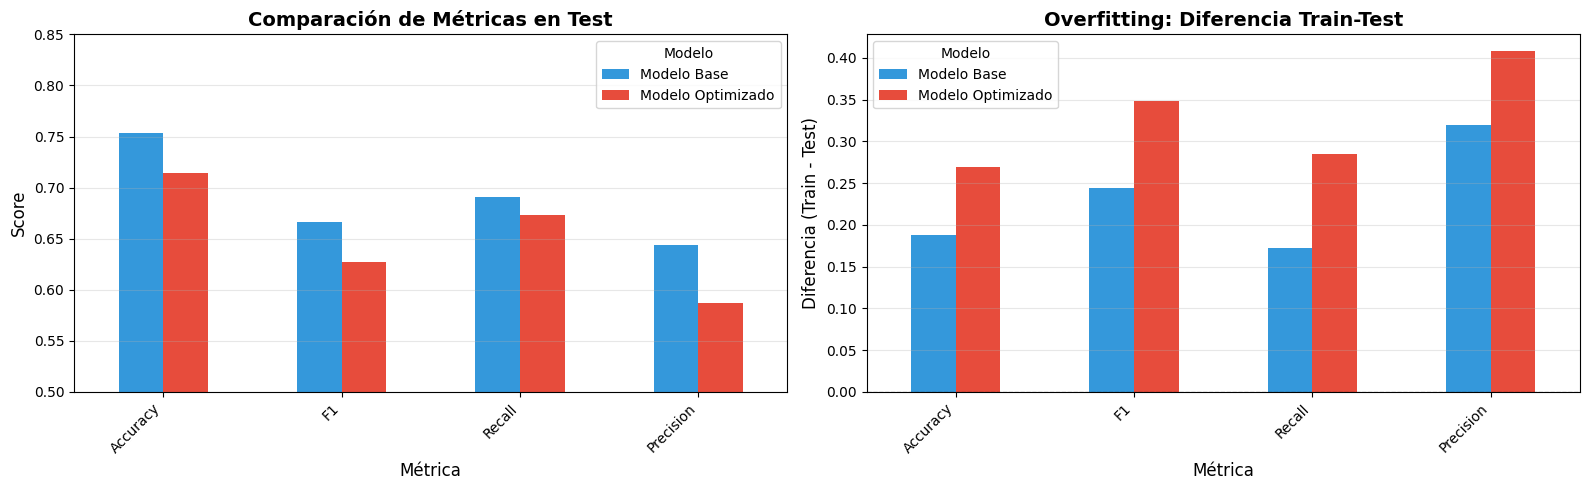

In [9]:
# Visualización de la comparación
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Gráfico 1: Comparación de métricas en Test
comparison_test = pd.DataFrame({
    'Modelo Base': base_metrics.loc['Test', ['Accuracy', 'F1', 'Recall', 'Precision']],
    'Modelo Optimizado': best_metrics.loc['Test', ['Accuracy', 'F1', 'Recall', 'Precision']]
})

comparison_test.plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c'])
axes[0].set_title('Comparación de Métricas en Test', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_xlabel('Métrica', fontsize=12)
axes[0].legend(title='Modelo', fontsize=10)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_ylim([0.5, 0.85])

# Gráfico 2: Comparación del Overfitting (Diferencia Train-Test)
comparison_diff = pd.DataFrame({
    'Modelo Base': base_metrics.loc['Diferencia', ['Accuracy', 'F1', 'Recall', 'Precision']],
    'Modelo Optimizado': best_metrics.loc['Diferencia', ['Accuracy', 'F1', 'Recall', 'Precision']]
})

comparison_diff.plot(kind='bar', ax=axes[1], color=['#3498db', '#e74c3c'])
axes[1].set_title('Overfitting: Diferencia Train-Test', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Diferencia (Train - Test)', fontsize=12)
axes[1].set_xlabel('Métrica', fontsize=12)
axes[1].legend(title='Modelo', fontsize=10)
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

# 4.1 Guardamos el modelo

In [10]:
# Guardar el modelo base (mejor desempeño)
model_path = '/workspaces/carlos060495-intro-ml/models/gradient_boosting_diabetes.pkl'

with open(model_path, 'wb') as file:
    pickle.dump(model, file)

print("✅ Modelo base guardado exitosamente")
print(f"📁 Ubicación: {model_path}")
print("\n📊 Hiperparámetros del modelo guardado:")
print("=" * 50)
print(f"n_estimators: {model.n_estimators}")
print(f"learning_rate: {model.learning_rate}")
print(f"max_depth: {model.max_depth}")
print(f"min_samples_leaf: {model.min_samples_leaf}")
print("=" * 50)

✅ Modelo base guardado exitosamente
📁 Ubicación: /workspaces/carlos060495-intro-ml/models/gradient_boosting_diabetes.pkl

📊 Hiperparámetros del modelo guardado:
n_estimators: 100
learning_rate: 0.1
max_depth: 3
min_samples_leaf: 5
